[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cako/experiments/blob/main/ceci-nest-pas-un-chien/CeciNestPasUnChien.ipynb)

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/cako/experiments/main?filepath=ceci-nest-pas-un-chien%2FCeciNestPasUnChien.ipynb)

![Image of three dogs, the two rightmost ones are modified so as to be categorized as a cat](dog-cat-cat.png)

# Ceci n'est pas un chien

Author: Carlos Alberto da Costa Filho


## Introduction

Convolutional networks transform input objects (such as images) into an output object which can be another image (e.g. denoised version of the input), a categorization of the input (e.g. if it is a cat or a dog), or something else entirely (e.g. representation of the features of the input).

Convolutional networks are highly-dimensional, complex objects which are notoriously hard to visualize and interpret. Below you can see the architecture of the ResNet50, which is composed of dozens of layers whose weights control the behavior of the network.
<br>
![Resnet50v2 architecture](resnet50v2_resize.png)
<br>
A common way of visualizing the weights is by generating images which maximize the activation of specific layers. [This approach](https://keras.io/examples/vision/visualizing_what_convnets_learn/) allows us to peek at the kinds of patterns certain layers learn. It is well known that while the shallowest layers detect simple features such as edges, deeper layers may understand textures and complex spatial patterns. A good example of this can be found in an [old Keras blog entry](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html) about visualizing convolutional networks.

## How to turn a dog into a cat

If we take the idea of maximizing activations to the extreme, the deepest layer of all is the output layer. Resnet50, when trained with [ImageNet](https://www.kaggle.com/c/imagenet-object-localization-challenge/data?select=LOC_synset_mapping.txt), has 1000 output neurons, each corresponding to a specific object. For example, output neuron 30 corresponds to identifying an axolotl, and 842 corresponds to sweatshirts. In this notebook we are going to explore obtaining images which maximize some of these outputs. This will give us an insight into what the network thinks the "most sweatshirt image" of all images is, or what the "catest" image looks like.

What we will find is that these rarely make much sense, and in reality, images can be altered only slightly (to the human perception), in a way that "tricks" the network into thinking the image is something else. It turns out this is not simply an academic concern. Certain convolutional networks can be so frail that [one pixel change alters the output of the network](https://www.bbc.com/news/technology-41845878). Our examples won't be so dramatic, but as the top image shows, ResNet50 can easily be fooled.

So read on and let's have some fun!

# Imports

In [1]:
%matplotlib inline
import logging
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

from PIL import Image
try:
    from tqdm.notebook import trange, tqdm
except ImportError:
    print("You should try tqdm to progress bars!")
    print("Install with `python3 -m pip install tqdm`")
    trange = range
    tqdm = lambda x: x
plt.style.use('seaborn-colorblind')

In [2]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Apr 25 2021

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.21.0

tensorflow       : 2.4.1
logging          : 0.5.1.2
matplotlib       : 3.4.0
tensorflow_addons: 0.12.1
PIL              : 7.0.0
numpy            : 1.19.2

Watermark: 2.2.0



# Randomly generated pups? 🐶

In the following cells we will set up a crude optimization for maximizing the output neurons. We will build on and improve it later. The first thing to do is to load the first load the ResNet network with pretrained weights based on ImageNet.

In [3]:
model = tf.keras.applications.ResNet50V2(weights="imagenet", include_top=True)

Now we will set up our optimization loop. This loop is quite straight forward: The first step is taking an initial image and using the pretrained model to obtain the likelihood our image is of a certain certain class. We then calculate the gradient of this likelihood with respect to the image. This gradient tells us in which direction we should update the initial image so as to increase the likelihood. So we update the image and restart the loop. Summarizing:

1. Create starting image;
2. With the current image, compute likelihood;
3. Take gradient of likelihood w.r.t image;
4. Use gradient to update image;
5. Return to step 2.

Mathematically, this is called "[gradient descent](https://en.wikipedia.org/wiki/Gradient_descent)" and can be written as:

$$
\mathbf{img}_{n+1} = \mathbf{img}_n - \alpha \nabla f(\mathbf{img}_n)
$$

Where $f$ is the likelihood of a certain class. TensorFlow will compute $\nabla f(\mathbf{img}_n)$ by automatic differentiation, we don't need to code it in directly.

In [4]:
# Step 1: Create starting image
tf.random.set_seed(23)
input_shape = tuple(map(lambda x: 1 if x is None else x, model.input.shape)) # (1, 224, 224, 3)
img0 = tf.random.uniform(input_shape, minval=0, maxval=1, dtype=model.dtype)
img0 = (img0 - 0.5) * 0.25 # Input should be between -1 and 1, we start with -0.125, 0.125
tf.reduce_max(img0)

<tf.Tensor: shape=(), dtype=float32, numpy=0.12499848>

In [5]:
# Choose classid from the ImageNet categories
with open("LOC_synset_mapping.txt") as f:
    categories = []
    for l in f.readlines():
        desc = l.split(' ', 1)[1].strip()
        categories.append(desc)

def find_classid_by_description(description: str, categories: list):
    for i, c in enumerate(categories):
        if description.lower() in c.lower():
            return i

classid = find_classid_by_description('labrador', categories)
categories[classid]

'Labrador retriever'

In [6]:
iterations = 40
learning_rate = 10 # How fast we'd like to move towards the maximum, the "alpha" in the above equation

# Create updateable variable with `img0` as starting value
img = tf.Variable(initial_value=img0, trainable=True)

lhoods = []
gradns = []
print("Iteration | Likelihood | Gradient norm")
print("--------------------------------------")
for it in range(iterations):
    # Step 2: Compute loss
    # If you're not familiar with Keras, this context manager allows us to record
    # the operations on `img` so as to compute the gradient later on
    with tf.GradientTape() as tape:
        tape.watch(img)
        pred = model(img)
        lhood = pred[:, classid]
    
    # Store loss
    lhoods.append(lhood[0].numpy())
    
    # Step 3: Compute gradient of likelihood w.r.t the image
    grad = tape.gradient(lhood, img)
    
    # Store gradient norm before we rescale
    gradns.append(tf.norm(grad).numpy())

    # Step 3a: Precondition gradient
    # Normalize and damp by likelihood: when reaching the maximum, scale down the gradient up to 90%
    # This guarantees that small gradients near the optimum don't stay the same size
    grad = tf.math.l2_normalize(grad) * (1-np.min([lhoods[-1], 0.9]))

    # Step 4: update image
    # This is equivalent to img += learning_rate * grads, but Variables are a bit peculiar
    img.assign(img + learning_rate * grad)

    # Make sure the image remains between -1 and 1
    img.assign(tf.clip_by_value(img, -1, 1))
    
    if (it+1) % 5 == 0:
        print("  %02d/%d   |   %.4f   | %.2g" % (it+1, iterations, lhoods[-1], gradns[-1]))

Iteration | Likelihood | Gradient norm
--------------------------------------
  05/40   |   0.0013   | 0.0056
  10/40   |   0.0015   | 0.0028
  15/40   |   0.0324   | 0.14
  20/40   |   0.2722   | 1.2
  25/40   |   0.9989   | 0.0042
  30/40   |   1.0000   | 7.5e-05
  35/40   |   1.0000   | 4.6e-06
  40/40   |   1.0000   | 1.5e-06


Now we need to understand the results. Before we look at the image, let's first try to get an intuition over the trustworthiness of the result. The first thing to look at is the loss. As shown in the table above, we achieved a loss of 1. This means that ResNet is virtually 100% sure that our output image is a Labrador retriever. The second thing to look at is the gradient: very near the optimum, the gradient should be near zero. Indeed, we also observe this from the table above.

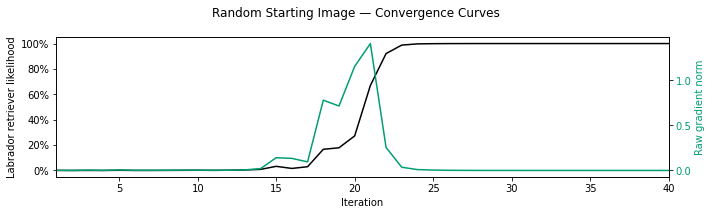

In [7]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(range(1, iterations+1), 100*np.array(lhoods), color='k')
ax.set(xlim=[1,iterations], xlabel="Iteration", ylabel=f"{categories[classid]} likelihood")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

ax2 = ax.twinx()
color='C1'
ax2.plot(range(1, iterations+1), gradns, color=color)
ax2.set_ylabel('Raw gradient norm', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.suptitle("Random Starting Image — Convergence Curves")
fig.tight_layout()

We can also have a more holistic view of how these quantities change throughout the iterations. The plot above shows that somewhere near iteration 20, we found a good direction to follow which increased our gradient and also our loss. Our loss quickly stabilizes near 100% as we reach the maximum, and our gradient rapidly decays to zero.

So everything is making sense so far. We're ready for the big reveal! Oh, but before we do that, we need to convert our `img` tensor to an actual image. We will follow François Chollet, the author of Keras on this, and use the following function to convert our image to RGB.

In [8]:
def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= np.max([img.std(), 1e-5])
    img *= 0.15
    img += 0.5

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

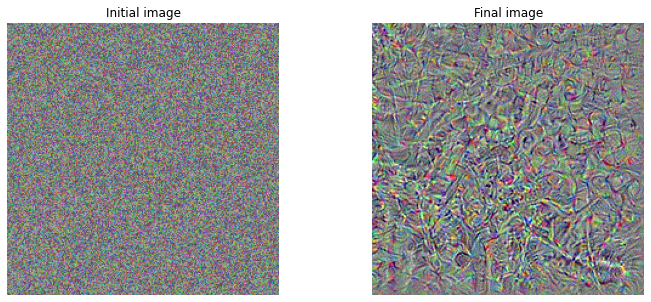

In [9]:
# View input and results
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(deprocess_image(img0[0,...].numpy()))
ax[1].imshow(deprocess_image(img[0,...].numpy()))
ax[0].set(title='Initial image')
ax[1].set(title='Final image')
for ax_ in ax:
    ax_.axis('off')

Wow! It sure did something. But did it create a dog?

While I don't think so, the network vehemently disagrees! It ensures us that this is, in fact, 100% a dog. 🐶🤔

Well, let's not take it at its face value. Remember I mentioned one-pixel attacks? Are we sure this is not happening here? Let's make sure of that.

# Heatmaps: Oh my God, they're everywhere!

A great way of checking if you're network is "doing the right thing" is to modify the input image in certain ways and checking how the network changes its classification. Andrew Ng tells a story of a wolf/dog discriminator trained on thousands of images with exceptional accuracy. One particular dog image, however, kept being misclassified as a wolf, no matter how much tweaking they did. And it wasn't even a husky. Upon inspection, they realized an interesting thing about this photo: it was taken during a snowy winter... Well, it turned out that the network wasn't really using the dogs' faces for classification, but rather the backgrounds: the wolves photos were all taken with a snowy backgrounds, heavily biasing the classifier. The story might be apocryphal, but it alerts us to the fact that deep-learning models are tricky, and we best make sure they are looking at the right parts.

In order to do so, we will follow the approach of the [Stanford CS231n course](https://cs231n.github.io/understanding-cnn/) on convolutional networks and create an _occlusion map_ for our image. An occlusion map is created by systematically occluding parts of the image — and rerunning the prediction to see how the network responds. In the example above, an occlusion map would have helps the researchers realize that occluding the dogs/wolves would have had no effect on their classification. Occlusion maps also allow us to test the susceptibility of our network to one-pixel attacks.

In [10]:
def mask_image(img, mask):
    img_m = img.copy()
    img_m[:, mask, :] = 0.
    return img_m

def occlusion_heatmap(images, classid, stride=1, radius=20, progress=False):
    n_images, width, height = images.shape[:-1]
    n_rangew = len(range(0, width, stride))
    n_rangeh = len(range(0, height, stride))
    heat = np.zeros((n_images, n_rangew, n_rangeh))
    
    range_w = range(n_rangew)
    if progress:
        range_w = trange(n_rangew)

    X, Y = np.ogrid[:width, :height]
    for ix in range_w:
        for iy in range(n_rangeh):
            centerw, centerh = ix*stride, iy*stride
            mask = (X - centerw)**2 + (Y-centerh)**2 <= radius**2
            img_mask = mask_image(images, mask) # Occlude `radius` sized region around (centerw,centerh) 
            pred = model.predict(tf.convert_to_tensor(img_mask)) # Predict the occluded image
            heat[:, ix, iy] = pred[:, classid]
    return heat

In [11]:
occ_map = occlusion_heatmap(img.numpy(), classid, stride=5, radius=30, progress=True)

  0%|          | 0/45 [00:00<?, ?it/s]

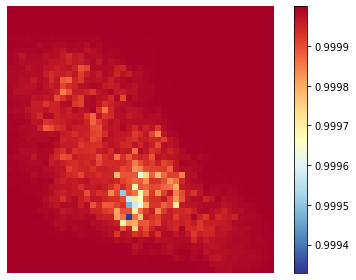

In [12]:
fig, ax = plt.subplots()
im = ax.imshow(occ_map[0,...], cmap="RdYlBu_r")
ax.axis('off')
fig.colorbar(im)
fig.tight_layout()

Oh my! Look at that colorbar. The whole image is dogs! We were worried about a few parts of the image dominating, but rather the opposite is happening. No matter which part of the image we occlude, we always get "dog". When we occlude the center-bottom part of the image, the worse the network does is a 99.93%.

How would this map look for an actual dog? Well, let's find out!

In [13]:
def crop_center(pil_img, crop_width=None, crop_height=None):
    img_width, img_height = pil_img.size
    crop_width = crop_height = min(img_width, img_height)
    return pil_img.crop(((img_width - crop_width) // 2,
                         (img_height - crop_height) // 2,
                         (img_width + crop_width) // 2,
                         (img_height + crop_height) // 2))

def array_from_pil(image):
    t = tf.keras.preprocessing.image.img_to_array(image)[np.newaxis,...]
    return (t - 127.5) / 127.5

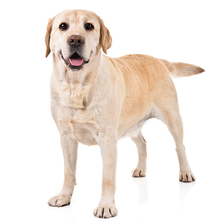

In [14]:
img_dog = Image.open("Yellow-Labrador-Retriever.jpg")
img_dog = crop_center(img_dog)
img_dog = img_dog.resize((224, 224), Image.ANTIALIAS)
img_dog

In [15]:
occ_map_dog = occlusion_heatmap(array_from_pil(img_dog), classid, stride=5, radius=30, progress=True)

  0%|          | 0/45 [00:00<?, ?it/s]

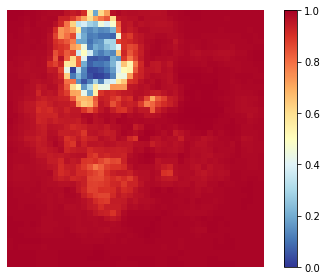

In [16]:
fig, ax = plt.subplots()
im = ax.imshow(occ_map_dog[0,...], vmin=0, vmax=1, cmap="RdYlBu_r")
ax.axis('off')
fig.colorbar(im)
fig.tight_layout()

Ok, so that looks more reasonable. Occluding the region around what seems to be the face of the dog completely destroys the network's performance. Occluding just about any other part of the image does not seem to matter much to the network. Let's quickly just overlay this with the dog image to see if the dog's face lines up with the feature above.

In [17]:
def upsample(heat, stride):
    w, h = model.input_shape[-3:-1]
    layer = tf.keras.layers.UpSampling2D(
        (stride, stride), input_shape=(*heat.shape[1:], 1), interpolation='bilinear')

    up = tf.keras.Sequential()
    up.add(layer)
    return up.predict(tf.convert_to_tensor(heat[:,:,:,np.newaxis]))[:,:w,:h,0]

def grayscale_to_pil(image, cmap="RdYlBu_r"):
    cm = plt.get_cmap(cmap)
    colored_image = cm(image)
    return Image.fromarray((colored_image[:, :, :3] * 255).astype(np.uint8))

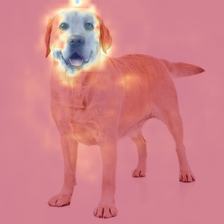

In [18]:
img_dog_alpha = img_dog.copy()
img_dog_alpha.putalpha(255)
occ_map_dog_rescaled = upsample(occ_map_dog, 5)
mask_alpha = grayscale_to_pil(occ_map_dog_rescaled[0,...])
mask_alpha.putalpha(128)

img_dog_composite = Image.alpha_composite(img_dog_alpha, mask_alpha)
img_dog_composite

Looks good! We have learned that natural images like the image of dog has "dog-like" features in a very small part of the actual image. As expected, these parts coincide with the regions like the face of the dog. We have also learned that when we bluntly optimize the network to generate a certain class, the network will change the image so as to be characterized as a dog (in this example) everywhere. It won't discriminate a particular part, it will just try to ensure any patch of the image is "dog-like" (in its interpretation of what that it).

If we remember the wolves, this actually makes complete sense: a randomly started image should not discriminate the position of the pixels/features. It stands to reason then, that every part of the image is updated uniformly.

# Ceci n'est pas un chien

Now that we have an image of the dog, how about we try to "trick" the network into thinking it is something else? With the machinery we developed we can do this very simply by altering parts of the image in a way that maximizes another class. We will use the Siamese cat for this example, but any of the 999 output types can be used.

Instead of running the loops manually, we will create a Python class to do everything we need with only one function. It seems like a huge class, but if you look closely, it doesn't do too much more than the code we saw before.

In [19]:
class ClassIDMaximizer():
    """
    Obtains an image which maximizes a certain class.
    
    Parameters
    ----------
    classid: int
        Will try to maximize this class
    
    model: Keras model
        Uses this model to predict
        
    img0: array, optional
        Starting image. Should be of size (n_images, nh, nw, nc). If not provided, will be initialized randomly.
    
    n_images: int, optional
        Number of starting images if `img0` is not provided (defaults to 1).
    
    n_iterations: int, optional
        Number of iterations. Defaults to 20.
    
    optimizer: Keras optimizer, optional
        Defaults to stochastic gradient descent (SDG) with the learning rate provided
    
    learning_rate: int, optional
        Learning rate for default optimizer. Defaults to 10. Ignored if non-default optimizer is used.
    
    gradient_preconditioners: list, optional
        Functions which will be applied to the gradients prior to being passed to the optimizer to update the
        image. By default, it scales the images by its L2 norms.
    
    damp_grad: float, optional
        Scales the gradient by 1 - min(likelihood, damp_grad). When 0, does not alter the gradient.
        When 1, scales gradient by 1-likelihood. Numbers between 0 and 1 set the maximum amount the]
        gradient can be damped by. Defaults to 0.
    
    output_likelihoods: bool, optional
        Stores and outputs likelihoods for all iterations. Defaults to True.
    
    output_images: bool, optional
        Stores and outputs images for all iterations. Defaults to False.
        
    progress: bool, optional
        Uses progress bars (requires tqdm). Defaults to True.
    """
    def __init__(self,
                 classid,
                 model,
                 img0=None,
                 n_images=None,
                 iterations=40,
                 optimizer=None,
                 learning_rate=10.,
                 gradient_preconditioners=None,
                 damp_grad=0.,
                 output_likelihoods=True,
                 output_images=False,
                 progress=True):
        self.classid = classid
        self.model = model
        if img0 is None:
            if n_images is None:
                n_images = 1
            # Random image
            input_shape = tuple(map(lambda x: n_images if x is None else x, model.input.shape))
            img0 = tf.random.uniform(input_shape, minval=0, maxval=1, dtype=model.dtype)
            img0 = (img0 - 0.5) * 0.25
        else:
            if n_images is None:
                n_images = img0.shape[0]
            elif n_images < img0.shape[0]:
                logging.info(f"Using only the first {n_images} of {img0.shape[0]} images provided.")
            elif n_images > img0.shape[0]:
                logging.warn(f"Not enough images. Will use the {img0.shape[0]} images provided.")
        
        self.img0 = img0
        self.n_images = n_images
        self.iterations = iterations
        if optimizer is None:
            self.optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
        else:
            self.optimizer = optimizer
        
        if gradient_preconditioners is None:
            gradient_preconditioners = [tf.math.l2_normalize]
        self.gradient_preconditioners = gradient_preconditioners
        self.damp_grad = damp_grad
        self.output_likelihoods = output_likelihoods
        self.output_images = output_images
        
        self.progress = progress
        return
    
    @tf.function
    def likelihood(self, pred, classid):
        return pred[:, classid]
    
    def run(self, iterations=None):
        # Backprop will happen on this Variable
        img = tf.Variable(initial_value=self.img0, trainable=True)
        
        # Use class iterations if not supplied
        if iterations is None:
            iterations = self.iterations
        
        # Losses will be stored here
        if self.output_likelihoods:
            likelihoods = np.zeros((iterations, img.shape[0]))
        if self.output_images:
            images = np.zeros((iterations, *img.shape))
        
        # Progress bar if required
        myrange = range(iterations)
        if self.progress:
            myrange = trange(iterations, desc='Iterations')

        for it in myrange:
            # While storing computations, compute losses
            with tf.GradientTape() as tape:
                tape.watch(img)
                pred = self.model(img)
                lhood = self.likelihood(pred, self.classid)
                loss = -lhood # Optimizers minimize by default
            
            # Compute gradient losses w.r.t each image w.r.t. 
            grads = tape.gradient(loss, img)

            # Precondition gradient
            for precon in self.gradient_preconditioners:
                grads = tf.map_fn(precon, grads)

            damp = (1 - tf.minimum(lhood[:,tf.newaxis,tf.newaxis,tf.newaxis], self.damp_grad))
            grads = grads * damp
            
            # Update image
            self.optimizer.apply_gradients([(grads, img)])
            
            img.assign(tf.clip_by_value(img, -1, 1))
            
            if self.output_likelihoods:
                likelihoods[it, ...] = lhood.numpy()
            if self.output_images:
                images[it, ...] = img.numpy()
        
        output = []
        if self.output_images:
            output.append(images)
        else:
            output.append(img.numpy())
        if self.output_likelihoods:
            output.append(likelihoods)
        else:
            output.append(lhood.numpy())
        return tuple(output)

There's a lot to digest about the class above, but let's do a simple test to ensure it is doing what we expect. Let's run it with the same parameters we ran the simple code in the previous section and let's compare their results. We don't expect them to match exactly since `ClassIDMaximizer` uses a Keras-provided optimizer, but they should be somewhat similar.

In [20]:
random_maxim = ClassIDMaximizer(208, model, img0=img0, damp_grad=0.9)
images_random, lhoods_random = random_maxim.run()

Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

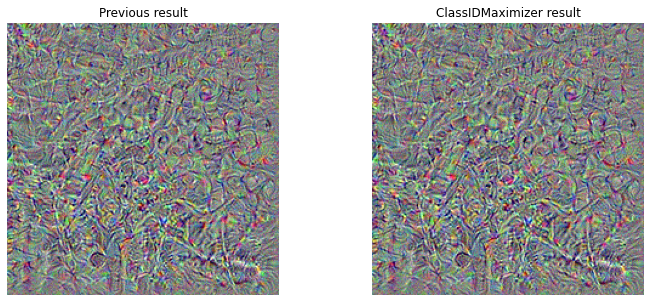

In [21]:
# View input and results
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(deprocess_image(img[0,...].numpy()))
ax[1].imshow(deprocess_image(images_random[0,...]))
ax[0].set(title='Previous result')
ax[1].set(title='ClassIDMaximizer result')
for ax_ in ax:
    ax_.axis('off')

Let's try to make our dog look like a cat.

In [22]:
class_siam = find_classid_by_description("siamese", categories)
categories[class_siam]

'Siamese cat, Siamese'

In [23]:
def pil_to_tensor(image):
    out = np.array(img_dog) # To array
    out = (out - 127.5) / 127.5 # Center and scale
    out = tf.convert_to_tensor(out, dtype=model.dtype) # Convert to tensor of appropriate type
    out = tf.expand_dims(out, axis=0) # Reshape to (1, nh, nw, nc)
    return out

In [24]:
dog_maxim = ClassIDMaximizer(class_siam, model, img0=pil_to_tensor(img_dog), damp_grad=0.8, learning_rate=30)
images_dog, lhoods_dog = dog_maxim.run()

Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

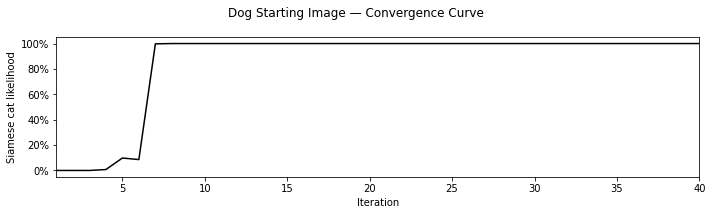

In [25]:
iters = range(1, len(lhoods_dog) + 1)
label = categories[class_siam].split(',')[0]
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(iters, 100*np.array(lhoods_dog), color='k')
ax.set(xlim=[1,len(iters)], xlabel="Iteration", ylabel=f"{label} likelihood")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
fig.suptitle("Dog Starting Image — Convergence Curve")
fig.tight_layout()

Convergence curve looks good. And now:

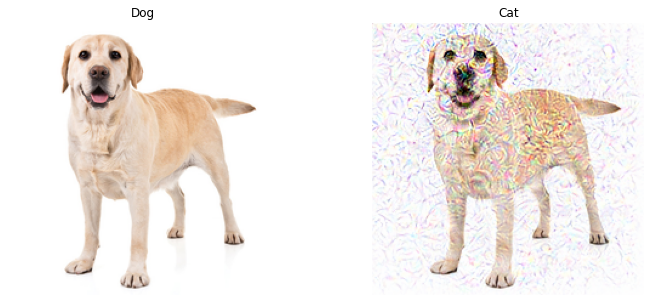

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(img_dog)
ax[1].imshow(np.uint8(images_dog[0,...]*127.5 + 127.5))
ax[0].set(title='Dog')
ax[1].set(title='Cat')
for ax_ in ax:
    ax_.axis('off')

That's a very psychedelic cat! 😺🌈

We have successfully managed to trick our network into thinking this psychedelic dog is actually a cat. Can we do better? We'll, let's lean onto the gradient preconditioning further.

We are going to: mask, smooth and remove rough edges (with 2D FFT) so as to have a more controlled gradient only where we want.

In [27]:
@tf.function
def prep_mask(mask_in, filter_shape=(5, 5)):
    mask = tfa.image.median_filter2d(mask_in, filter_shape=filter_shape)
    mask = tfa.image.mean_filter2d(mask, filter_shape=filter_shape)
    mask = tf.repeat(mask, 3, axis=-1)
    return mask

# Mask 1: Do not alter white background
mask_bg = tf.cast(np.array(img_dog) < 254, dtype=model.dtype)
mask_bg = tf.reduce_mean(mask_bg, axis=-1, keepdims=True)
mask_bg = prep_mask(mask_bg)

# Mask 2: Focus on face
mask_fc = 1. - occ_map_dog_rescaled[0,...]
mask_fc[mask_fc > 0.3] = 1.
mask_fc[mask_fc < 0.1] = 0.
mask_fc = mask_fc**2
mask_fc = tf.cast(mask_fc, dtype=model.dtype)
mask_fc = tf.expand_dims(mask_fc, -1)
mask_fc = prep_mask(mask_fc, filter_shape=(11, 11))

# Final mask: multiply both
mask = mask_bg * mask_fc 

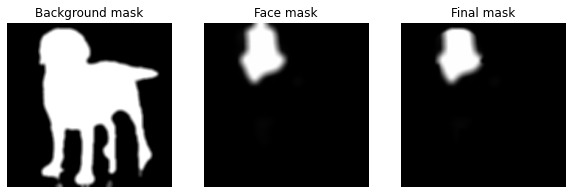

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
ax[0].imshow(mask_bg)
ax[1].imshow(mask_fc)
ax[2].imshow(mask)
for ax_, t in zip(ax, ['Background mask', 'Face mask', 'Final mask']):
    ax_.set(title=t)
    ax_.axis('off')

We need to create a TensorFlow function which applies this mask to each of the gradients. The function must receive an Tensor of shape (224, 224, 3), and output a Tensor of the same size. To ensure a closure arond the mask Tensor, we will do it in the following format:

In [29]:
def create_grad_mask(mask):
    @tf.function
    def grad_mask(grad):
        return grad * mask
    return grad_mask

In [30]:
precon_mask = create_grad_mask(mask)

But we won't stop there. We are going to smooth our gradient, as well as remove rought edges with the help of a radial $f$-$k$ filter. This will ensure that our gradient is slowly-varying.

In [31]:
def create_grad_smooth(**kwargs):
    @tf.function
    def grad_smooth(grad):
        return tfa.image.gaussian_filter2d(grad, **kwargs)
    return grad_smooth

def create_grad_fk_filter(input_shape, beta=12.0):
    tap1d_a = tf.signal.kaiser_window(input_shape[0], beta=beta)
    tap1d_b = tf.signal.kaiser_window(input_shape[1], beta=beta)
    fkmask = tf.tensordot(tap1d_a, tap1d_b, axes=0)

    @tf.function
    def grad_fk_filter(grad):
        channels = []
        for c in range(grad.shape[-1]):
            gradcast = tf.cast(grad[:,:,c], dtype=tf.complex64)
            grad_fk = tf.signal.fft2d(gradcast)
            grad_fk = tf.signal.fftshift(grad_fk)
            grad_fk = grad_fk * tf.cast(fkmask, dtype=tf.complex64)
            grad_fk = tf.signal.ifftshift(grad_fk)
            gradcast = tf.cast(tf.signal.ifft2d(grad_fk), dtype=tf.float32)
            channels.append(gradcast)
        new_grad = tf.stack(channels, axis=-1)
        return new_grad
    return grad_fk_filter

In [32]:
precon_smooth = create_grad_smooth(filter_shape=(3, 3))
precon_fk_filter = create_grad_fk_filter(model.input.shape[-3:-1], beta=15)

preconditioners = [tf.math.l2_normalize, precon_smooth, precon_fk_filter, precon_mask]

In [33]:
dog_maxim_fancy = ClassIDMaximizer(class_siam, model, img0=pil_to_tensor(img_dog), damp_grad=0.8, learning_rate=10,
                                   iterations=100, gradient_preconditioners=preconditioners)
images_dog_fancy, lhoods_dog_fancy = dog_maxim_fancy.run()

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

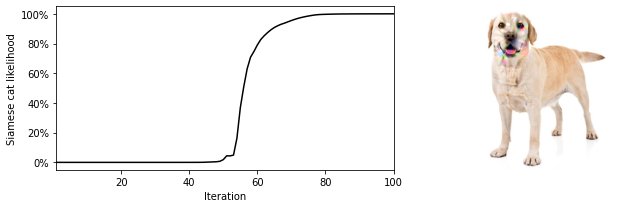

In [34]:
iters = range(1, len(lhoods_dog_fancy) + 1)
label = categories[class_siam].split(',')[0]

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].plot(iters, 100*np.array(lhoods_dog_fancy), color='k')
ax[0].set(xlim=[1,len(iters)], xlabel="Iteration", ylabel=f"{label} likelihood")
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter())

ax[1].imshow(np.uint8(images_dog_fancy[0,...]*127.5 + 127.5))
ax[1].axis('off')
fig.tight_layout()

And that's it for today! We have generated a slightly modified image of a dog which ResNet50 — of the most widely used networks out there — swears is a cat!

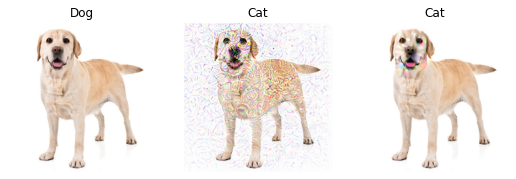

In [35]:
dpi = 120
figsize = (900/dpi, 300/dpi)
fig, ax = plt.subplots(1, 3, figsize=figsize)
ax[0].imshow(img_dog)
ax[1].imshow(np.uint8(images_dog[0,...]*127.5 + 127.5))
ax[2].imshow(np.uint8(images_dog_fancy[0,...]*127.5 + 127.5))
ax[0].set(title='Dog')
ax[1].set(title='Cat')
ax[2].set(title='Cat')
for ax_ in ax:
    ax_.axis('off')
fig.tight_layout()
fig.patch.set_facecolor('white')
fig.savefig('dog-cat-cat.png', dpi=dpi, transparent=False)

# Where to go from here?

On the one hand we were able to "trick" the network into thinking a dog is actually a cat. On the other, we seem unable to generate dog-like representations from brute maximization of the likelihood function. This makes sense: we are maximizing over a single dimension, hoping to generate a structure over a highly-dimensional space: that of 224 x 224 x 3 images.

With this in mind, it becomes clear what one must do to improve this: reduce the dimensionality of the input space! We need to somehow be able to capture morphological structures of the images into a few dimensions, instead of trying to work over the individual pixels. This presents an excellent opportunity for using autoencoders, more specifically [convolutional variational autoencoders](https://www.tensorflow.org/tutorials/generative/cvae) (CVAE).

CVAEs capture map images into a *latent* space (more specifically weights of probability distributions in the case of variational encoders). This latent space is much lower dimensional than the original image space, and therefore more suitable for the optimization we want to do. For example, the MNIST dataset contains black-and-white 28 x 28 images of digits from 0-9. This space is 784-dimensional. Using CVAEs, we can map it to two-dimensional space with virtually no loss of information. This is because while the ambient space is 784 dimensional, the space where the digits inhabit is essentially 2D.

Therefore, in order to get more "dog-like" images, we should first obtain an encoding of dog-like images, and perform the likelihood optimization over this space. The resulting encoding can then be decoded onto an actual image.